# Import necessary python packages

In [3]:
import dataclasses
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from matplotlib.ticker import FuncFormatter

# Data management related functions

In [4]:
def get_nodes() -> pl.DataFrame:
    authors = pl.read_csv("data/authors.csv").select(pl.col("server").alias("instance"))
    rebloggers = pl.read_csv("data/rebloggers.csv").select(
        pl.col("server").alias("instance")
    )
    nodes = pl.concat([authors, rebloggers]).unique()
    return nodes

In [5]:
def get_relationships() -> pl.DataFrame:
    relationships = (
        pl.read_csv("data/rebloggers.csv")
        .select(
            pl.col("server").alias("reblogger_instance"),
            pl.col("author_server").alias("author_instance"),
        )
        .group_by(["reblogger_instance", "author_instance"])
        .len(name="weight")
        .sort("weight", descending=True)
        .select("reblogger_instance", "author_instance", "weight")
    )
    return relationships

In [6]:
nodes = get_nodes()
relationships = get_relationships()

nodes.write_csv("nodes.csv")
relationships.write_csv("relationships.csv")
#!cp data/authors_03_04_10_2025.csv neo4j_db/import/authors_2.csv

FileNotFoundError: No such file or directory (os error 2): data/authors.csv

In [8]:
len(relationships)

126379

In [9]:
len(nodes)

5781

## Database related functions

In [3]:
def get_database_driver():
    uri = "bolt://localhost:7687"
    return GraphDatabase.driver(uri, auth=("neo4j", "my_password"))

In [11]:
def create_nodes() -> None:
    with get_database_driver().session() as session:
        session.run(
            "CREATE CONSTRAINT instance_name_unique IF NOT EXISTS FOR (i:Instance) REQUIRE i.instance IS UNIQUE"
        )
        session.run(
            """
            LOAD CSV WITH HEADERS FROM 'file:///nodes.csv' AS row
            CALL(row) {
                MERGE (i:Instance {instance: row.instance})
            } IN TRANSACTIONS
            """
        )

In [12]:
def create_relationships() -> None:
    with get_database_driver().session() as session:
        session.run(
            """
            LOAD CSV WITH HEADERS FROM 'file:///relationships.csv' AS row
            CALL (row){
              MATCH (r:Instance {instance: row.reblogger_instance })
              MATCH (a:Instance {instance: row.author_instance })
              MERGE (r)-[:REBLOGS {weight: toInteger(row.weight)}]->(a)
            } IN TRANSACTIONS
            """
        )

In [13]:
def delete_all_nodes_and_relationships() -> None:
    with get_database_driver().session() as session:
        session.run("MATCH (n) DETACH DELETE n")

### Execute database releated functions

In [16]:
# Uncomment the below lines to execute the functions you want.
# create_nodes()
# create_relationships()
# delete_all_nodes_and_relationships()

# Graph Analysis

Self-loops are not taking into account for any metric calc.

In [4]:
def run_query(query: str) -> pl.DataFrame:
    """
    Executes a Cypher query and returns the results directly as a Polars DataFrame.
    """
    driver = get_database_driver()  # Assumes this is defined elsewhere
    with driver.session() as session:
        result = session.run(query)
        # 1. Get the field names (headers)
        columns = list(result.keys())
        # 2. Get the raw data rows
        data = [record.values() for record in result]
        # 3. Create the Polars DataFrame directly (bypassing Pandas)
        return pl.DataFrame(data, schema=columns)

## Weakly/Strong Connected Components

In [88]:
def get_components(type_algorithm: str, mode: str = "stream") -> pl.DataFrame:
    if type_algorithm not in ["wcc", "scc"]:
        raise ValueError("Type algorithm must be 'wcc' or 'scc'")

    if mode == "stream":
        query = f"""
        CALL gds.{type_algorithm}.stream('reblogs-network-filtered')
        YIELD nodeId, componentId
        RETURN gds.util.asNode(nodeId).instance AS instance, componentId AS component_id
        ORDER BY component_id, instance
        """
    elif mode == "write":
        query = f"""
        CALL gds.{type_algorithm}.write('reblogs-network-filtered', {{writeProperty: 'componentId'}})
        YIELD componentCount, componentDistribution
        RETURN componentCount AS component_count,componentDistribution.max as max_set_size, componentDistribution.min as min_set_size
        """
    else:
        raise ValueError("Mode must be 'stream' or 'write'")

    no_self_loops = config.get("out_strength")

    project_query = f"""
    {no_self_loops}
    RETURN gds.graph.project(
        'reblogs-network-filtered',
        source,
        target,
        {{ relationshipProperties: r {{ .weight }} }}
    )
    """

    drop_query = """
    CALL gds.graph.drop('reblogs-network-filtered')
    YIELD graphName, nodeCount
    RETURN graphName, nodeCount"""

    run_query(project_query)
    results = run_query(query)
    run_query(drop_query)

    return results

In [89]:
df_wcc = get_components("wcc")
df_wcc.get_column("component_id").value_counts()

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


component_id,count
i64,u32
0,5778


In [90]:
# We write the propoerty componentId in each graph node.
df_scc = get_components("scc", mode="write")
df_scc

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


component_count,max_set_size,min_set_size
i64,i64,i64
4142,1637,1


## Degree Centrality (_OutDegree_ and _InDegree_)

In [11]:
df_outdegree = run_query("""
MATCH (i:Instance)
WITH i, count{ (i)-[:REBLOGS]->(other) WHERE i <> other } AS out_degree
RETURN i.instance AS instance, out_degree
ORDER BY out_degree DESC
""")

df_indegree = run_query("""
MATCH (i:Instance)
WITH i, count{ (i)<-[:REBLOGS]-(other) WHERE i <> other } AS in_degree
RETURN i.instance AS instance, in_degree
ORDER BY in_degree DESC
//RETURN apoc.agg.statistics(inDegree)
""")

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


In [15]:
df_outdegree

instance,out_degree
str,i64
"""mastodon.social""",1737
"""relay.fedi.buzz""",1272
"""mstdn.social""",980
"""mastodon.online""",810
"""mas.to""",785
…,…
"""social.biblionik.org""",0
"""vinzenz.social""",0
"""social.fz-juelich.de""",0


In [16]:
df_indegree

instance,in_degree
str,i64
"""mastodon.social""",3946
"""infosec.exchange""",1512
"""mstdn.social""",1342
"""chaos.social""",1333
"""tech.lgbt""",1193
…,…
"""dodgy.download""",0
"""joinfriendica.de""",0
"""social.sumeru.top""",0


In [17]:
@dataclasses.dataclass
class PlotData:
    ax: plt.Axes
    data: pd.DataFrame
    title: str
    x_label: str
    y_label: str
    column_x_label: str
    color: str
    column_y_label: str = ""


def plot_distribution(plot_data: list[PlotData]) -> None:
    for pld in plot_data:
        series = pld.data.get_column(pld.column_x_label)
        series_positive = series.filter(series > 0)
        series_log = series_positive.log10()
        sns.histplot(
            x=series_log,
            bins=30,
            kde=True,
            stat="density",
            color=pld.color,
            line_kws={"color": "black", "linewidth": 2},
            ax=pld.ax,
        )

        # Formateador para que el usuario vea 10^x en lugar de x
        def format_log_tick(x, pos):
            return f"$10^{{{x:.1f}}}$" if x % 1 != 0 else f"$10^{{{int(x)}}}$"

        pld.ax.xaxis.set_major_formatter(FuncFormatter(format_log_tick))

        # Etiquetas
        pld.ax.set_title(pld.title, fontsize=14)
        pld.ax.set_xlabel(pld.x_label, fontsize=12)
        pld.ax.set_ylabel("Densidad", fontsize=12)

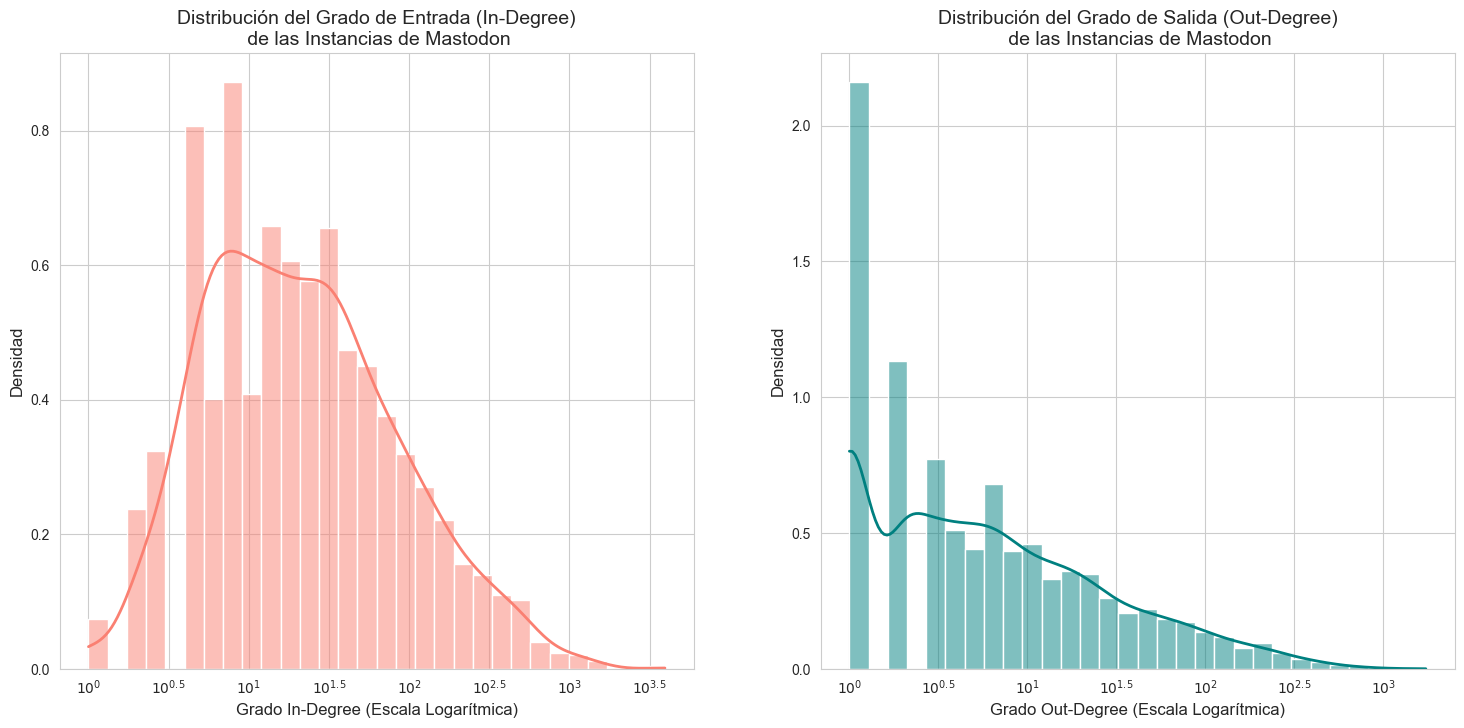

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
pld_indegree = PlotData(
    ax=ax1,
    data=df_indegree,
    column_x_label="in_degree",
    title="Distribución del Grado de Entrada (In-Degree)\n de las Instancias de Mastodon",
    x_label="Grado In-Degree (Escala Logarítmica)",
    y_label="Frecuencia (Conteo de Instancias)",
    color="salmon",
)

pld_outdegree = PlotData(
    ax=ax2,
    data=df_outdegree,
    column_x_label="out_degree",
    title="Distribución del Grado de Salida (Out-Degree)\n de las Instancias de Mastodon",
    x_label="Grado Out-Degree (Escala Logarítmica)",
    y_label="Frecuencia (Conteo de Instancias)",
    color="teal",
)
plot_distribution([pld_indegree, pld_outdegree]);

## Strength Distribution (_OutStrength_ and _InStrength_) without self-edges

In [19]:
config = {
    "out_strength": "MATCH (source:Instance)-[r:REBLOGS]->(target:Instance) WHERE source <> target",
    "in_strength": "MATCH (source:Instance)<-[r:REBLOGS]-(target:Instance) WHERE source <> target",
}


def get_strength_distribution_no_self_edge(strength_type: str) -> pl.DataFrame:
    match_query = config[strength_type]
    project_query = f"""
    {match_query}
    RETURN gds.graph.project(
      'reblogs-network-{strength_type}',
      source,
      target,
      {{ relationshipProperties: r {{ .weight }} }}
    )
    """
    # 2. Use gds.degree.stream
    stream_query = f"""
    CALL gds.degree.stream(
        'reblogs-network-{strength_type}',
        {{ relationshipWeightProperty: 'weight' }}
    )
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).instance AS instance, score AS {strength_type}
    ORDER BY {strength_type} DESC
    """

    # 3. Drop projection
    drop_query = f"""
    CALL gds.graph.drop('reblogs-network-{strength_type}')
    YIELD graphName, nodeCount
    RETURN graphName, nodeCount"""

    run_query(project_query)
    results = run_query(stream_query)
    run_query(drop_query)
    return results

In [20]:
df_in_strength = get_strength_distribution_no_self_edge("in_strength")
df_in_strength

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


instance,in_strength
str,f64
"""mastodon.social""",904112.0
"""bsky.brid.gy""",135450.0
"""mstdn.social""",120819.0
"""infosec.exchange""",110182.0
"""beige.party""",85120.0
…,…
"""dodgy.download""",0.0
"""joinfriendica.de""",0.0
"""social.sumeru.top""",0.0


In [21]:
df_out_strength = get_strength_distribution_no_self_edge("out_strength")
df_out_strength

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


instance,out_strength
str,f64
"""mastodon.social""",497385.0
"""mstdn.social""",152678.0
"""newsmast.community""",122570.0
"""mas.to""",94198.0
"""beige.party""",85670.0
…,…
"""mastodon.mossy.page""",0.0
"""pbs.idv.tw""",0.0
"""mashi.ro""",0.0


/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


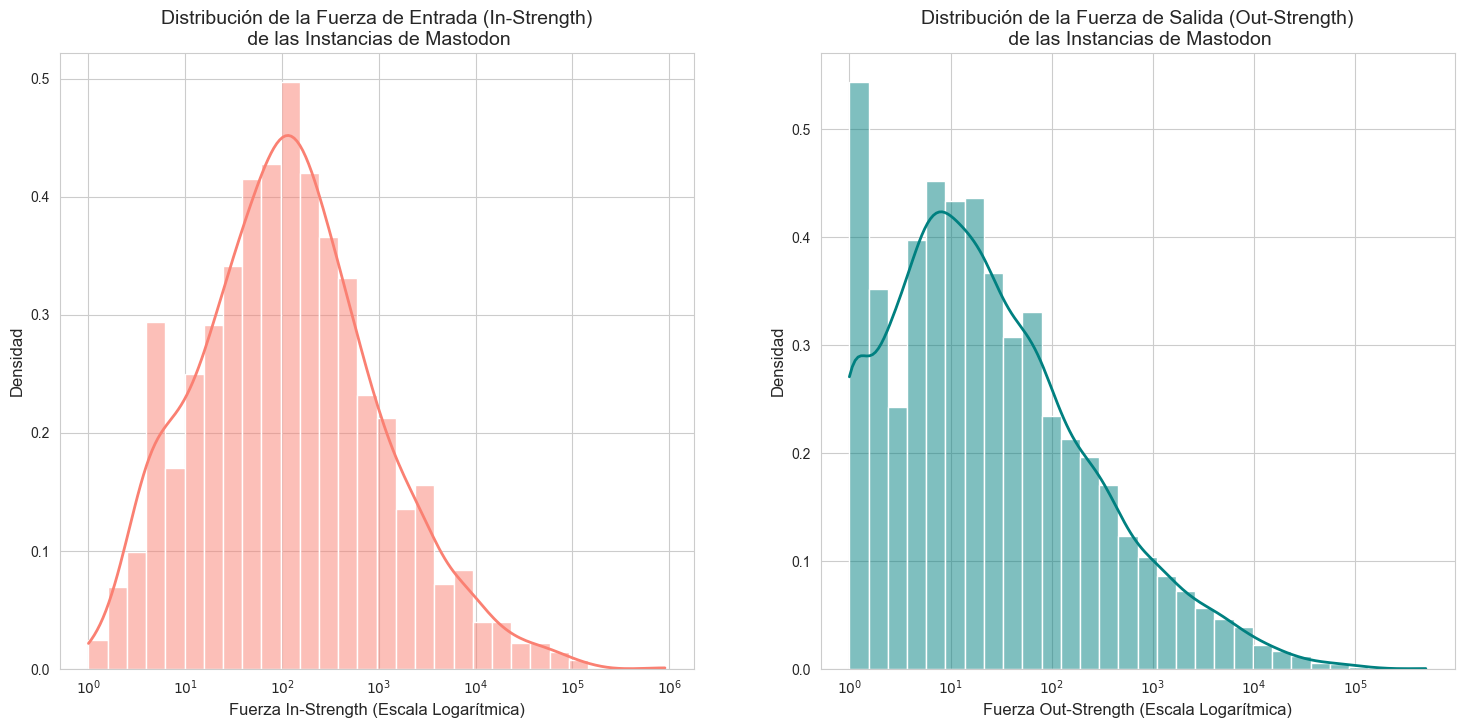

In [22]:
df_out_strength = get_strength_distribution_no_self_edge("out_strength")
df_in_strength = get_strength_distribution_no_self_edge("in_strength")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

pld_in_strength = PlotData(
    ax=ax1,
    data=df_in_strength.select("in_strength"),
    column_x_label="in_strength",
    title="Distribución de la Fuerza de Entrada (In-Strength)\n de las Instancias de Mastodon",
    x_label="Fuerza In-Strength (Escala Logarítmica)",
    y_label="Frecuencia (Conteo de Instancias)",
    color="salmon",
)

pld_out_strength = PlotData(
    ax=ax2,
    data=df_out_strength.select("out_strength"),
    column_x_label="out_strength",
    title="Distribución de la Fuerza de Salida (Out-Strength)\n de las Instancias de Mastodon",
    x_label="Fuerza Out-Strength (Escala Logarítmica)",
    y_label="Frecuencia (Conteo de Instancias)",
    color="teal",
)
plot_distribution([pld_in_strength, pld_out_strength])
plt.show()

## Betweenness Centrality

In [50]:
def get_betweenness_centrality() -> pl.DataFrame:
    # 1. Project query
    no_self_loops = config.get("out_strength")
    project_query = f"""
    {no_self_loops}
    RETURN gds.graph.project(
      'reblogs-network-filtered',
      source,
      target,
      {{ relationshipProperties: r {{ .weight }} }}
    )
    """

    stream_query = """
    CALL gds.betweenness.stream('reblogs-network-filtered')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).instance AS instance, score AS betweenness
    ORDER BY betweenness DESC
    """

    drop_query = """
    CALL gds.graph.drop('reblogs-network-filtered')
    YIELD graphName, nodeCount
    RETURN graphName, nodeCount"""

    run_query(project_query)
    betweenness = run_query(stream_query)
    run_query(drop_query)
    return betweenness

In [51]:
df_betweenness = get_betweenness_centrality().with_columns(
    betweenness=pl.col.betweenness.cast(pl.Int64)
)
df_betweenness

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


instance,betweenness
str,i64
"""mastodon.social""",5464288
"""chaos.social""",461810
"""mstdn.social""",432364
"""infosec.exchange""",379304
"""hachyderm.io""",287626
…,…
"""dodgy.download""",0
"""joinfriendica.de""",0
"""social.sumeru.top""",0


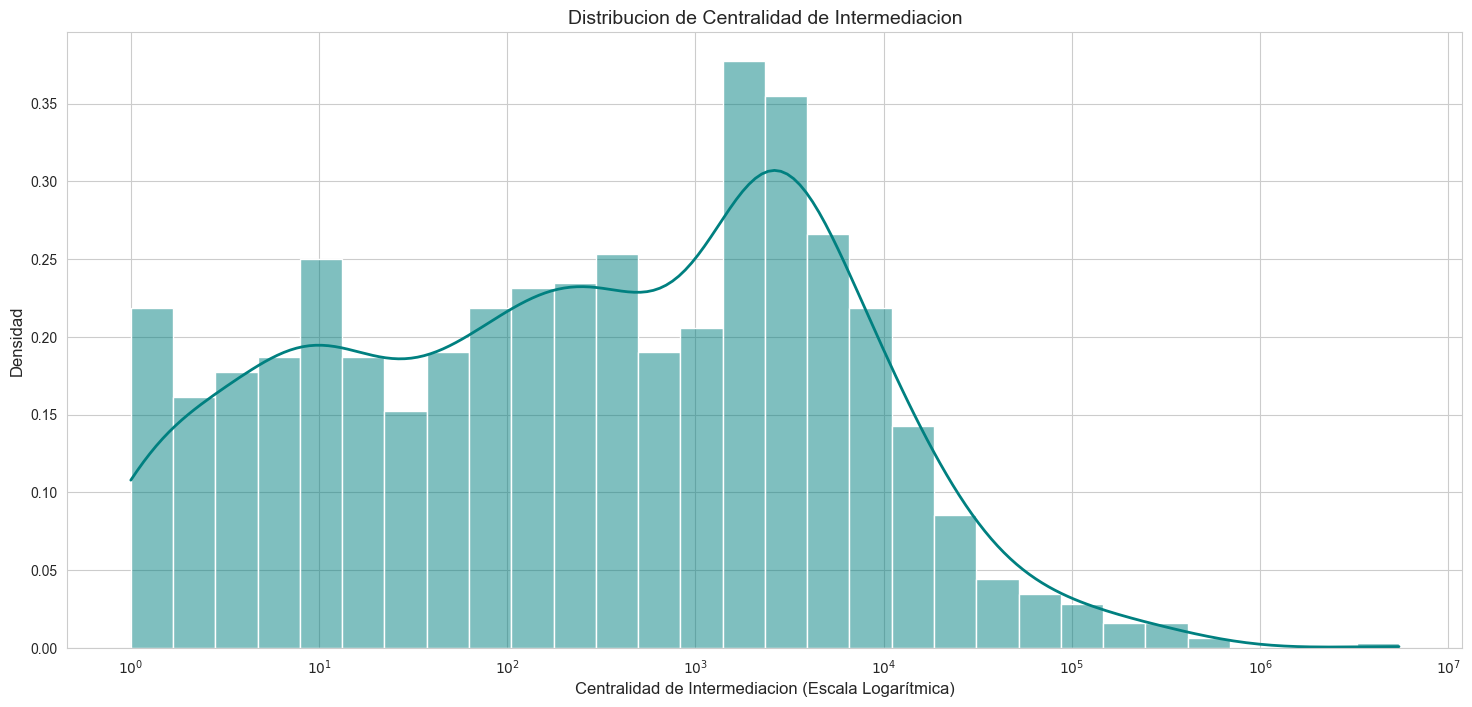

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))
pld_betweenness = PlotData(
    ax=ax1,
    data=df_betweenness.select("betweenness"),
    column_x_label="betweenness",
    title="Distribucion de Centralidad de Intermediacion",
    x_label="Centralidad de Intermediacion (Escala Logarítmica)",
    y_label="Frecuencia (Conteo de Instancias)",
    color="teal",
)

plot_distribution([pld_betweenness]);

# Betweenness vs degree

## In-Degree vs. Out-Degree

In [26]:
df_degrees = df_outdegree.join(df_indegree, how="inner", on="instance")
df_degrees

instance,out_degree,in_degree
str,i64,i64
"""mastodon.social""",1737,3946
"""infosec.exchange""",698,1512
"""mstdn.social""",980,1342
"""chaos.social""",754,1333
"""tech.lgbt""",525,1193
…,…,…
"""dodgy.download""",3,0
"""joinfriendica.de""",14,0
"""social.sumeru.top""",16,0


In [7]:
plt.figure(figsize=(10, 10))
max_in = df_degrees["in_degree"].max()
max_out = df_degrees["out_degree"].max()
max_val = max(max_in, max_out)

plt.plot(
    [1, max_val], [1, max_val], ls="--", c="r", alpha=0.5, label="Equilibrio (y=x)"
)

sns.scatterplot(
    data=df_degrees,  # <--- Polars nativo
    x="out_degree",
    y="in_degree",
    alpha=0.6,
    s=60,
    edgecolor="white",
    linewidth=0.5,
)

# --- 3. Escalas Logarítmicas ---
plt.xscale("log")
plt.yscale("log")

# --- 4. Etiquetas ---
plt.title("Mapa de Roles: Popularidad vs. Curación", fontsize=16)
plt.xlabel("Grado de Salida (Difusion) - Escala Log", fontsize=12)
plt.ylabel("Grado de Entrada (Popularidad) - Escala Log", fontsize=12)

# --- 5. Identificar al TOP 1 (Lógica Polars) ---
top_hub = df_degrees.sort("in_degree", descending=True).row(0, named=True)

plt.text(
    top_hub["out_degree"],
    top_hub["in_degree"],
    f"  {top_hub['instance']}",
    fontsize=11,
    fontweight="bold",
    va="center",
)

plt.grid(True, which="major", ls="-", alpha=0.2)
plt.grid(True, which="minor", ls=":", alpha=0.1)
plt.legend()

plt.show()

NameError: name 'df_degrees' is not defined

<Figure size 1000x1000 with 0 Axes>

In [35]:
correlation = df_degrees.select(
    pl.corr("out_degree", "in_degree", method="spearman")
).item()

print(f"Correlación de Spearman entre In-Degree y Out-Degree: {correlation:.2f}")

Correlación de Spearman entre In-Degree y Out-Degree: 0.31


## Fuerza Externa (Out-Strength) vs Fuerza de _self-loop_

In [28]:
def get_self_strength() -> pl.DataFrame:
    """
    Get the strength of the self-loop. That's simply the self-loop's weight.
    """
    query = """
    MATCH (i:Instance)
    OPTIONAL MATCH (i)-[r_self:REBLOGS]->(i)
    WITH i, coalesce(r_self.weight, 0) AS self_strength
    return i.instance AS instance, self_strength
    ORDER BY self_strength DESC
    """
    return run_query(query)


# Obtenemos los datos
df_self_strength = get_self_strength()
df_self_strength

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


instance,self_strength
str,i64
"""mastodon.social""",253688
"""bsky.brid.gy""",29568
"""flipboard.com""",27850
"""beige.party""",24074
"""mstdn.social""",11308
…,…
"""social.sumeru.top""",0
"""kaspernymand.com""",0
"""toot.fan""",0


In [29]:
df_self_and_out_strength = df_out_strength.join(df_self_strength, on="instance")
df_self_and_out_strength

instance,out_strength,self_strength
str,f64,i64
"""mastodon.social""",497385.0,253688
"""bsky.brid.gy""",2564.0,29568
"""flipboard.com""",0.0,27850
"""beige.party""",85670.0,24074
"""mstdn.social""",152678.0,11308
…,…,…
"""social.sumeru.top""",133.0,0
"""kaspernymand.com""",15.0,0
"""toot.fan""",15.0,0


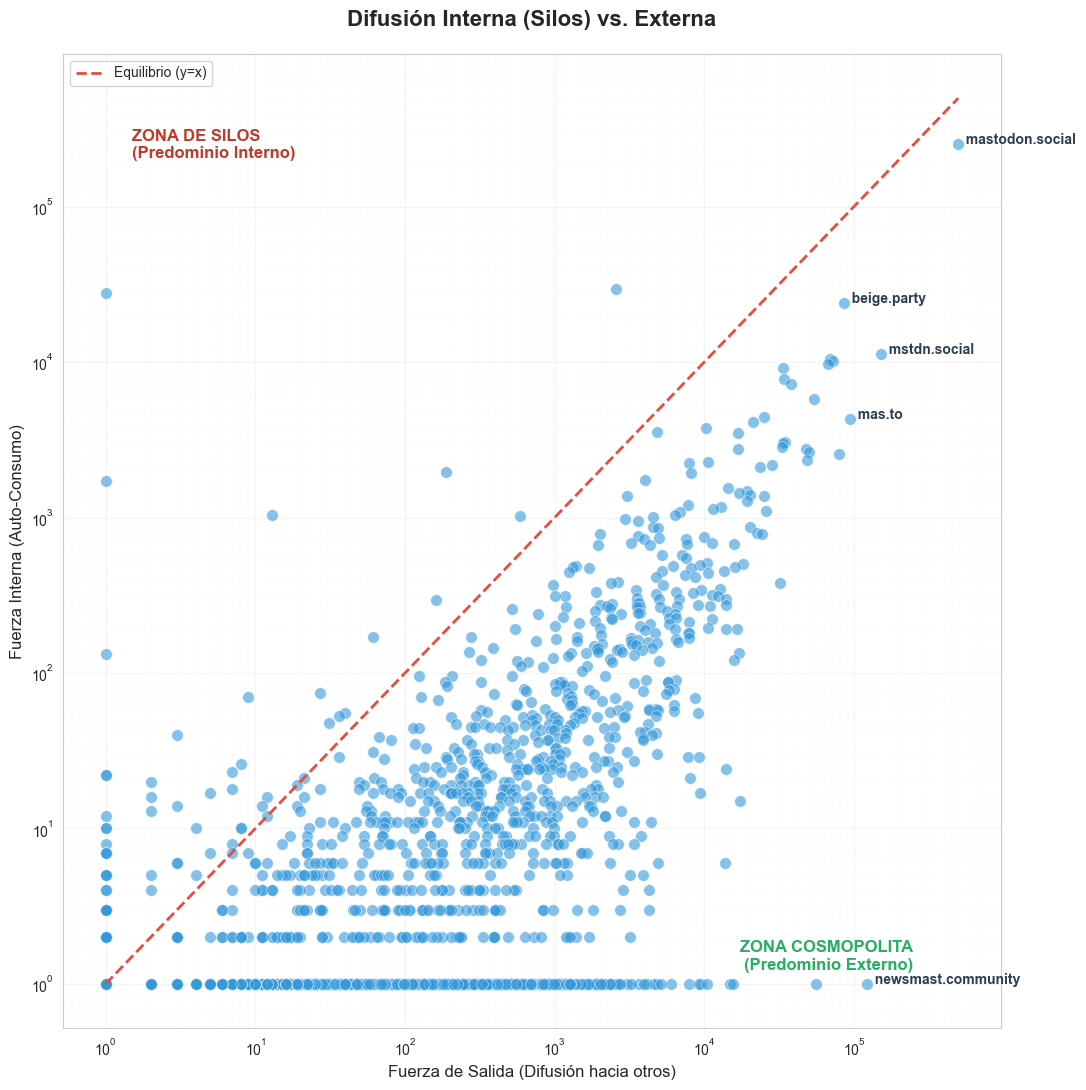

In [30]:
def plot_silo_hypothesis(df_strengths: pl.DataFrame):
    """
    Generate a plot to compare the "self" strength (the self-loop of each instance)
    and the external strength.
    """
    df_plot = df_strengths.with_columns(
        [
            (pl.col("self_strength") + 1).alias("plot_self"),
            (pl.col("out_strength") + 1).alias("plot_out"),
            (pl.col("self_strength") + pl.col("out_strength")).alias("total_activity"),
        ]
    )

    plt.figure(figsize=(11, 11))

    # Calc the limits to draw the limit line
    max_val = max(
        df_plot.get_column("plot_self").max(), df_plot.get_column("plot_out").max()
    )

    # Reference line (Equilibrio)
    plt.plot(
        [1, max_val],
        [1, max_val],
        color="#e74c3c",
        linestyle="--",
        linewidth=2,
        label="Equilibrio (y=x)",
    )

    sns.scatterplot(
        data=df_plot,
        x="plot_out",
        y="plot_self",
        alpha=0.6,
        s=70,
        edgecolor="white",
        linewidth=0.5,
        color="#3498db",
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.title(
        "Difusión Interna (Silos) vs. Externa", fontsize=16, fontweight="bold", pad=20
    )
    plt.xlabel("Fuerza de Salida (Difusión hacia otros)", fontsize=12)
    plt.ylabel("Fuerza Interna (Auto-Consumo)", fontsize=12)

    plt.text(
        1.5,
        max_val * 0.5,
        "ZONA DE SILOS\n(Predominio Interno)",
        fontsize=12,
        color="#c0392b",
        weight="bold",
        va="center",
    )
    plt.text(
        max_val * 0.5,
        1.5,
        "ZONA COSMOPOLITA\n(Predominio Externo)",
        fontsize=12,
        color="#27ae60",
        weight="bold",
        ha="right",
        va="center",
    )

    # --- Here we tag the HUBS (TOP INSTANCIAS) ---
    top_instances = df_plot.sort("total_activity", descending=True).head(5)

    for row in top_instances.iter_rows(named=True):
        plt.text(
            row["plot_out"],
            row["plot_self"],
            f"  {row['instance']}",
            fontsize=10,
            fontweight="bold",
            color="#2c3e50",
        )

    plt.legend(loc="upper left")
    plt.grid(True, which="major", ls="-", alpha=0.2)
    plt.grid(True, which="minor", ls=":", alpha=0.1)
    plt.tight_layout()
    plt.show()


plot_silo_hypothesis(df_self_and_out_strength)

## Grado vs Intermediación

In [53]:
def plot_bridges_detection(df_grades_betweenness: pl.DataFrame):
    df_plot = df_grades_betweenness.with_columns(
        [(pl.col("in_degree") + pl.col("out_degree")).alias("total_degree")]
    )

    # Add +1 to avoid log(0) errors
    df_plot = df_plot.with_columns(
        [
            (pl.col("total_degree") + 1).alias("log_degree"),
            (pl.col("betweenness") + 1).alias("log_betweenness"),
        ]
    )

    plt.figure(figsize=(12, 10))

    # Scatter Plot
    sns.scatterplot(
        data=df_plot,
        x="log_degree",
        y="log_betweenness",
        alpha=0.5,
        color="purple",
        edgecolor="white",
        s=60,
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.title(
        "Detección de Puentes: Conectividad vs. Importancia Estratégica",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("Grado Total (In + Out)", fontsize=12)
    plt.ylabel("Centralidad de Intermediación", fontsize=12)

    # Buscamos nodos con ALTO Betweenness pero BAJO Grado relativo.
    top_betweenness = df_plot.sort(
        ["betweenness", "total_degree"], descending=[True, False]
    ).head(2)

    for row in top_betweenness.iter_rows(named=True):
        plt.text(
            row["log_degree"],
            row["log_betweenness"],
            f"  {row['instance']}",
            fontsize=10,
            fontweight="bold",
        )

    plt.grid(True, which="major", ls="-", alpha=0.2)
    plt.grid(True, which="minor", ls=":", alpha=0.1)
    plt.tight_layout()
    plt.show()

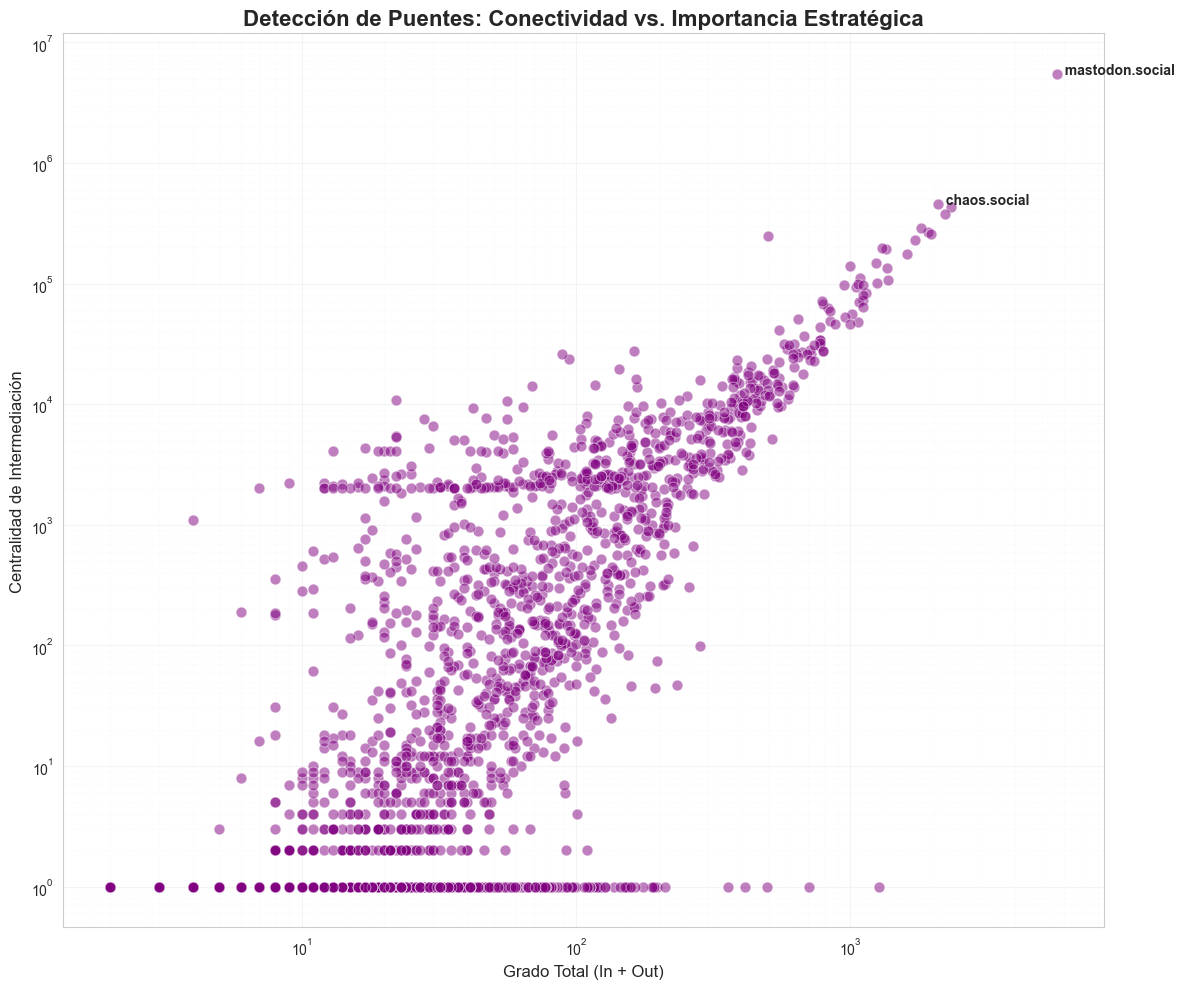

In [54]:
df_combined = (
    df_indegree.join(df_outdegree, on="instance", how="inner")
    .join(df_betweenness, on="instance", how="inner")
    .fill_null(0)
)
plot_bridges_detection(df_combined)

##  Grado vs Fuerza

In [33]:
df_strengths = df_out_strength.join(df_in_strength, on="instance")
df_combined = df_strengths.join(df_degrees, on="instance")
df_combined

instance,out_strength,in_strength,out_degree,in_degree
str,f64,f64,i64,i64
"""mastodon.social""",497385.0,904112.0,1737,3946
"""infosec.exchange""",69314.0,110182.0,698,1512
"""mstdn.social""",152678.0,120819.0,980,1342
"""chaos.social""",67003.0,74499.0,754,1333
"""tech.lgbt""",20087.0,50745.0,525,1193
…,…,…,…,…
"""dodgy.download""",15.0,0.0,3,0
"""joinfriendica.de""",39.0,0.0,14,0
"""social.sumeru.top""",133.0,0.0,16,0


In [34]:
def plot_scaling_law(df_combined: pl.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(
        "Ley de Escala: Relación entre Topología (Grado) y Flujo (Fuerza)",
        fontsize=16,
        fontweight="bold",
    )

    # --- PANEL 1: DINÁMICA DE SALIDA (Curación/Difusión) ---
    # Eje X: Out-Degree, Eje Y: Out-Strength
    sns.scatterplot(
        data=df_combined,
        x="out_degree",
        y="out_strength",
        ax=axes[0],
        alpha=0.5,
        color="teal",
        edgecolor=None,
        s=40,
    )
    # Línea de regresión para visualizar la pendiente (Beta)
    sns.regplot(
        data=df_combined,
        x="out_degree",
        y="out_strength",
        ax=axes[0],
        scatter=False,
        color="black",
        line_kws={"linestyle": "--", "linewidth": 1},
    )

    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_title("Dinámica de Difusión (Out-Degree vs. Out-Strength)", fontsize=14)
    axes[0].set_xlabel("Grado de Salida ($k_{out}$)", fontsize=12)
    axes[0].set_ylabel("Fuerza de Salida ($s_{out}$)", fontsize=12)
    axes[0].grid(True, which="both", ls="--", alpha=0.2)

    # --- PANEL 2: DINÁMICA DE ENTRADA (Popularidad) ---
    # Eje X: In-Degree, Eje Y: In-Strength
    sns.scatterplot(
        data=df_combined,
        x="in_degree",
        y="in_strength",
        ax=axes[1],
        alpha=0.5,
        color="salmon",
        edgecolor=None,
        s=40,
    )
    sns.regplot(
        data=df_combined,
        x="in_degree",
        y="in_strength",
        ax=axes[1],
        scatter=False,
        color="black",
        line_kws={"linestyle": "--", "linewidth": 1},
    )

    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_title(
        "Dinámica de Popularidad (In-Degree vs. In-Strength)", fontsize=14
    )
    axes[1].set_xlabel("Grado de Entrada ($k_{in}$)", fontsize=12)
    axes[1].set_ylabel("Fuerza de Entrada ($s_{in}$)", fontsize=12)
    axes[1].grid(True, which="both", ls="--", alpha=0.2)

    # Ajuste final
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    filename = "ley_de_escala_final.png"
    plt.savefig(filename, dpi=300)
    print(f"Gráfico guardado como '{filename}'")
    plt.show()

Gráfico guardado como 'ley_de_escala_final.png'


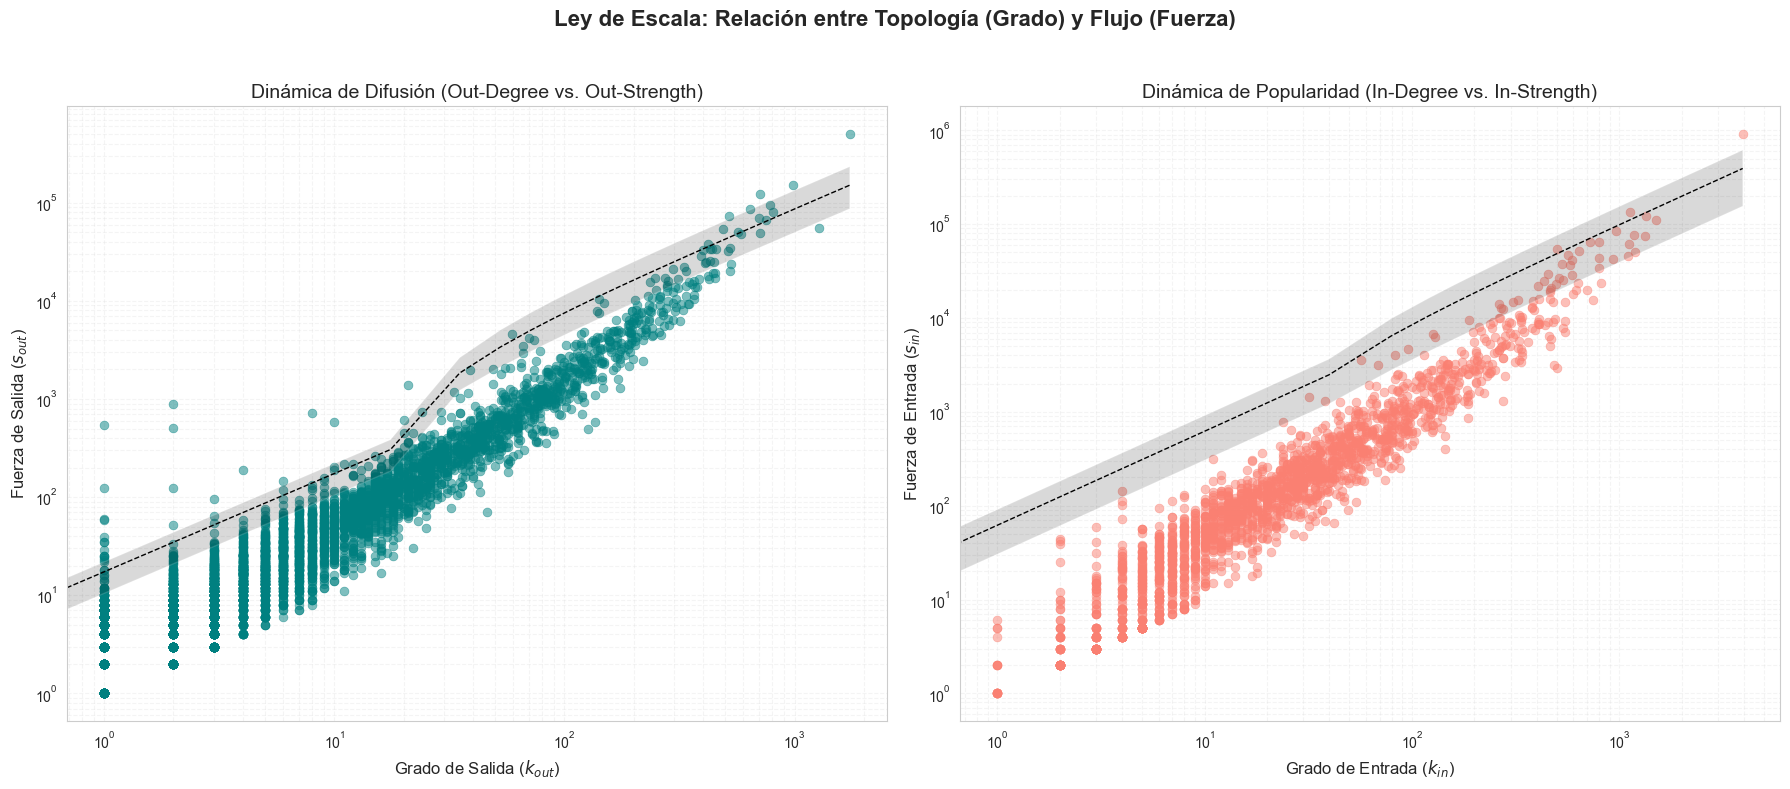

In [35]:
plot_scaling_law(df_combined)

## Coeficiente de Clustering vs Grado

In [36]:
def get_local_clustering() -> pl.DataFrame:
    no_self_loops = config.get("out_strength")
    project_query = f"""
    {no_self_loops}
    RETURN gds.graph.project(
      'reblogs-network-filtered',
      source,
      target,
      {{ relationshipProperties: r {{ .weight }} }},
      {{ undirectedRelationshipTypes: ['*'] }}
    )
    """

    stream_query = """
    CALL gds.localClusteringCoefficient.stream('reblogs-network-filtered')
    YIELD nodeId, localClusteringCoefficient
    RETURN
        gds.util.asNode(nodeId).instance AS instance,
        localClusteringCoefficient AS lcc
    ORDER BY lcc DESC
    """

    drop_query = """
    CALL gds.graph.drop('reblogs-network-filtered')
    YIELD graphName, nodeCount
    RETURN graphName, nodeCount"""

    run_query(project_query)
    results = run_query(stream_query)
    run_query(drop_query)

    return results

In [39]:
df_clustering_coefficient = get_local_clustering()
df_clustering_coefficient.head()

/var/folders/p4/l545fffs18v_cqqgxv7w5bj40000gp/T/ipykernel_14208/260932845.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(data, schema=columns)


instance,lcc
str,f64
"""socks.masto.host""",1.0
"""andeby.city""",1.0
"""sacred.harpy.faith""",1.0
"""valinwolf.com""",1.0
"""bonfire.fishinthecalculator.me""",1.0


In [42]:
def plot_clustering_vs_degree(df_plot: pl.DataFrame):
    plt.figure(figsize=(12, 8))

    sns.scatterplot(
        data=df_plot,
        x="total_degree",
        y="lcc",
        alpha=0.4,
        color="teal",
        edgecolor=None,
        s=40,
    )
    plt.xscale("log")
    # El eje Y (LCC) es lineal (0 a 1), no logarítmico
    plt.ylim(-0.05, 1.05)

    # Etiquetas
    plt.title(
        "Estructura de Mundo Pequeño: Clustering vs. Grado",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("Grado Total (Escala Logarítmica)", fontsize=12)
    plt.ylabel("Coeficiente de Agrupamiento Local (LCC)", fontsize=12)

    # Identificar a los Gigantes
    # ¿Tienen los Hubs un clustering bajo
    top_hubs = df_plot.sort("total_degree", descending=True).head(5)

    for row in top_hubs.iter_rows(named=True):
        plt.text(
            row["total_degree"],
            row["lcc"],
            f"  {row['instance']}",
            fontsize=10,
            fontweight="bold",
            color="black",
        )

    plt.grid(True, which="major", ls="-", alpha=0.2)
    plt.tight_layout()

    plt.savefig("clustering_vs_degree.png", dpi=300)
    print("Gráfica guardada.")
    plt.show()

Gráfica guardada.


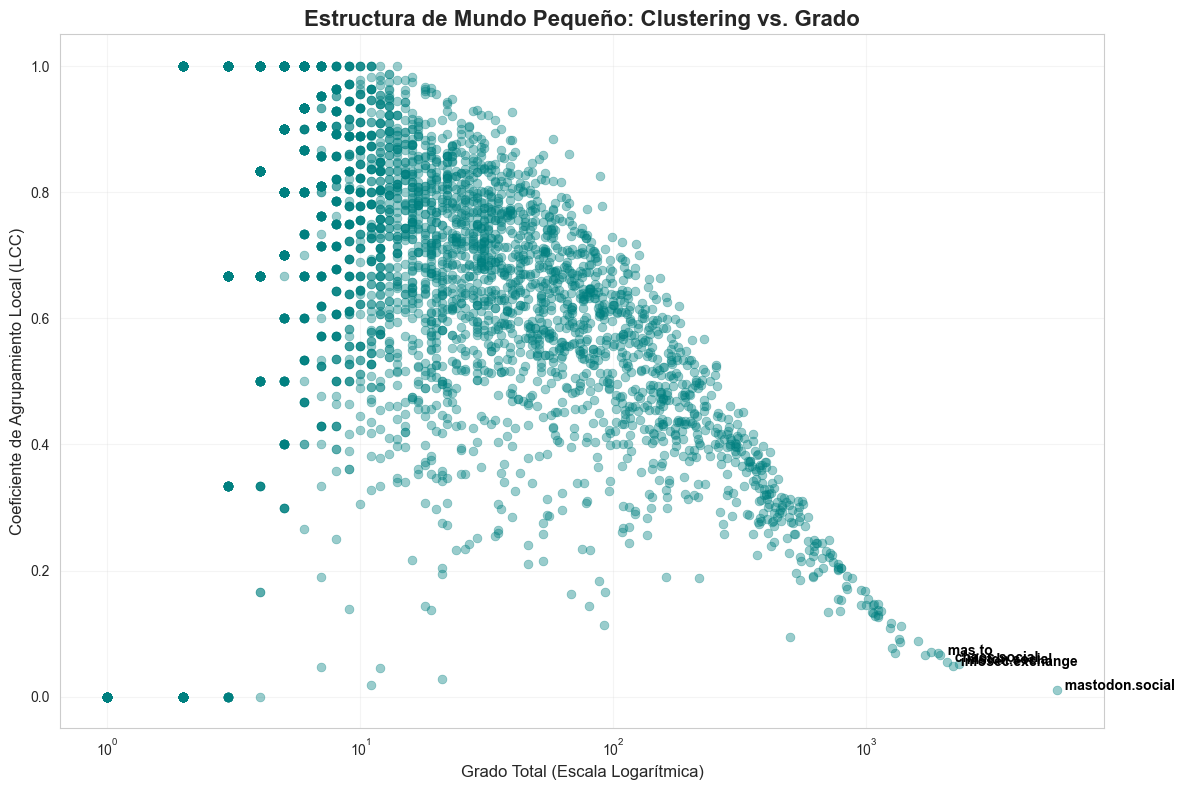

In [43]:
df_plot = df_degrees.with_columns(
    (pl.col("in_degree") + pl.col("out_degree")).alias("total_degree")
).join(df_clustering_coefficient, on="instance", how="inner")

plot_clustering_vs_degree(df_plot)